# A.) PREDICTION DES VARIABLES CU(bar), Φ

## Importation des differente librairie

In [1]:
#Importation des packages nécessaires a l'analyse
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
import scipy
from numpy import array
import statsmodels.formula.api as smf
from pandas.api.types import is_numeric_dtype, is_object_dtype
from scipy.stats import norm
from scipy import stats

####
##Librairie pour extraire le model
####
import joblib

## Visualization des donnees (5 premiere ligne)

In [2]:
#Importation de la base de données 

data=pd.read_excel('UU.xlsx')
data.head()

,Wl(%),IP(%),%ag à 80µm,Cu(bar),Φ(degree)
0,49.8,22.5,79.1,0.346,24.1
1,67.4,38.4,35.3,0.632,36.5
2,67.4,38.4,82.6,0.063,35.8
3,59.6,25.0,87.7,0.370,33.4
4,52.6,25.0,87.7,0.110,34.7


In [3]:
data.shape

(496, 5)

In [4]:
data.isnull().sum()

Wl(%)         0
IP(%)         0
%ag à 80µm    0
Cu(bar)       0
Φ(degree)     1
dtype: int64

In [5]:
data = data.dropna()

In [6]:
data.isnull().sum()

Wl(%)         0
IP(%)         0
%ag à 80µm    0
Cu(bar)       0
Φ(degree)     0
dtype: int64

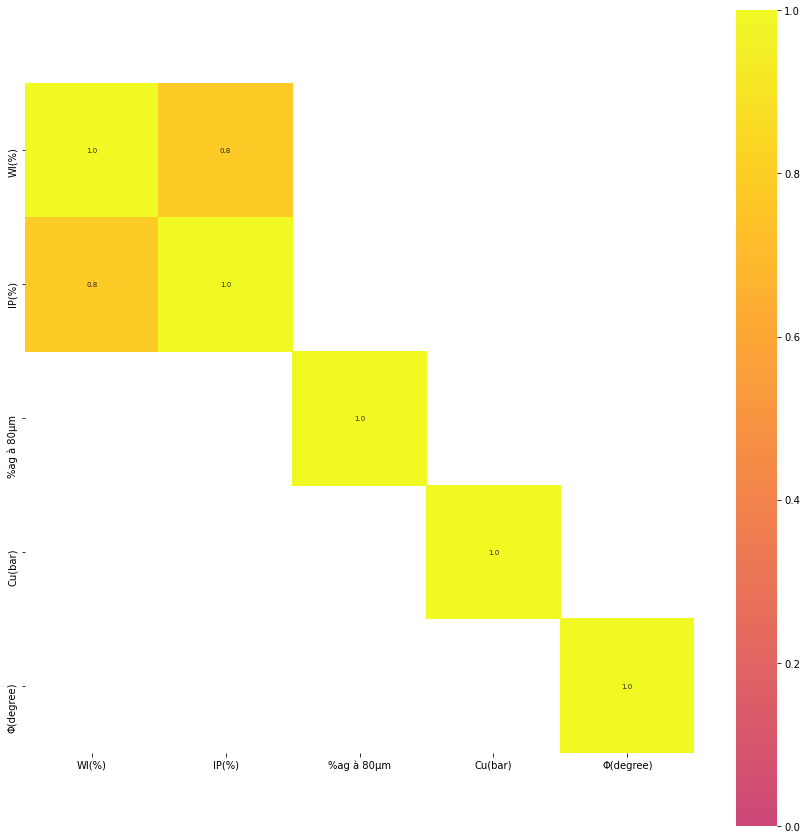

In [7]:
#If plot the Heat map for features with correlation more than 75% we get below plot 
corrmat = data.corr()
f, ax = plt.subplots(figsize=(15, 15))
sb.heatmap(corrmat, vmin = 0,vmax=1, square=True, cmap = 'plasma', annot = True,mask= corrmat < 0.75, fmt = '.1f', 
            linecolor = 'black', center = 0,annot_kws={"size": 7},)
plt.show()

## Resume des donnees (Analyse descriptive)

Fonction pour ontenir les variables categorielle et continu.

In [8]:
def get_cat_num_features(df):
    num_features = []
    cat_features = []

    for col in df.columns:
        if is_numeric_dtype(df[col]):
            num_features.append(col)

        if is_object_dtype(df[col]):
            cat_features.append(col)

    return num_features, cat_features

Fonction pour obtenir les valuer unique de chaque variable continu dans les donnees.

In [9]:
def get_unique_df(features):
    unique_df = pd.DataFrame(columns=['Feature', 'Unique', 'Count'])

    for col in features.columns:
        v = features[col].unique()
        l=len(v)
        unique_df= unique_df.append({'Feature':col, 'Unique':v, 'Count':l}, ignore_index=True)
    return unique_df

Foncion pour obtenir les valeurs null dans chaque columns / variable.

In [10]:
def get_null_df(features):
    col_null_df = pd.DataFrame(columns = ['Column', 'Type', 'Total NaN', '%'])
    col_null =features.columns[features.isna().any()].to_list()
    L = len(features)
    for col in col_null:
        T=0
        if is_numeric_dtype(features[col]):
            T = "Numerical"
        else:
            T = "Categorical"

        ##Get the null values in a particular column
        nulls = len(features[features[col].isna() == True][col])
        col_null_df = col_null_df.append({'Column':col,
                                         'Type': T,
                                         'Total NaN': nulls,
                                         '%': (nulls/L)*100}, ignore_index=True)

    return col_null_df

Fonction pour obtenir une vue d'ensemble de l'analyse des donnees.

In [11]:
def summary(data):
    print("Samples ---->", len(data))
    print()
    target = data['Cu(bar)']
    features = data.drop(['Cu(bar)'], axis=1)
    print("Features -->", len(features.columns))
    print("\n", list(features.columns))

    num_features, cat_features = get_cat_num_features(features)

    print()
    print(" Numerical Features --> ", len(num_features))
    print()
    print('Numerical Features -->',num_features)
    print()
    print("Categorical Features -->", len(cat_features))
    print()
    print('Categorical Features -->',cat_features)
    print("********************************************")
    stats = features.describe().T

    print()
    print("Value counts of each categorial features\n")    

    for col in cat_features:
        print(col)
        print(features[col].value_counts())
        print()

    unique_df = get_unique_df(features)

    col_null_df = get_null_df(features)

    return {'features': features, 'target': target, 'stats': stats, 'unique_df':unique_df, 'col_null_df':col_null_df}

In [12]:
df_summary = summary(data)

Samples ----> 495

Features --> 4

 ['Wl(%)', 'IP(%)', '%ag à 80µm', 'Φ(degree)']

 Numerical Features -->  4

Numerical Features --> ['Wl(%)', 'IP(%)', '%ag à 80µm', 'Φ(degree)']

Categorical Features --> 0

Categorical Features --> []
********************************************

Value counts of each categorial features



## Analyse Descriptive

In [13]:
df_summary['stats']

,count,mean,std,min,25%,50%,75%,max
Wl(%),495.0,59.893131,14.445954,0.0,52.650,59.60,68.00,149.0
IP(%),495.0,24.981838,11.563219,0.0,18.000,22.60,29.70,111.0
%ag à 80µm,495.0,68.735737,21.797111,0.8,56.225,72.73,85.65,100.0
Φ(degree),495.0,32.360606,8.483707,2.0,28.800,34.00,37.20,52.6


## Verification de l'existance des valeur null dans les donnees

In [14]:
df_summary['col_null_df']

,Column,Type,Total NaN,%


Vus que le tableau produit est vide alors il n'en existe pas. La technique de valeur null utiliser depend de la concentration des valeur manquante.

## Verification de l'existance des valeur unique dans chaque variable

In [15]:
df_summary['unique_df']

,Feature,Unique,Count
0,Wl(%),"[49.8, 67.4, 59.6, 52.6, 60.7, 52.0, 65.0, 69....",210
1,IP(%),"[22.5, 38.4, 25.0, 29.2, 22.4, 23.0, 16.0, 38....",178
2,%ag à 80µm,"[79.1, 35.3, 82.6, 87.7, 89.0, 78.9, 69.0, 85....",246
3,Φ(degree),"[24.1, 36.5, 35.8, 33.4, 34.7, 39.9, 18.8, 34....",185


In [16]:
X = data.drop(['Cu(bar)','Φ(degree)','IP(%)'],axis=1)
Y = data['Cu(bar)']
Y1 = data["Φ(degree)"]

In [17]:
features_names = list(X.columns)

## Test d'indepence entre les different parametre a explique les variables a predire

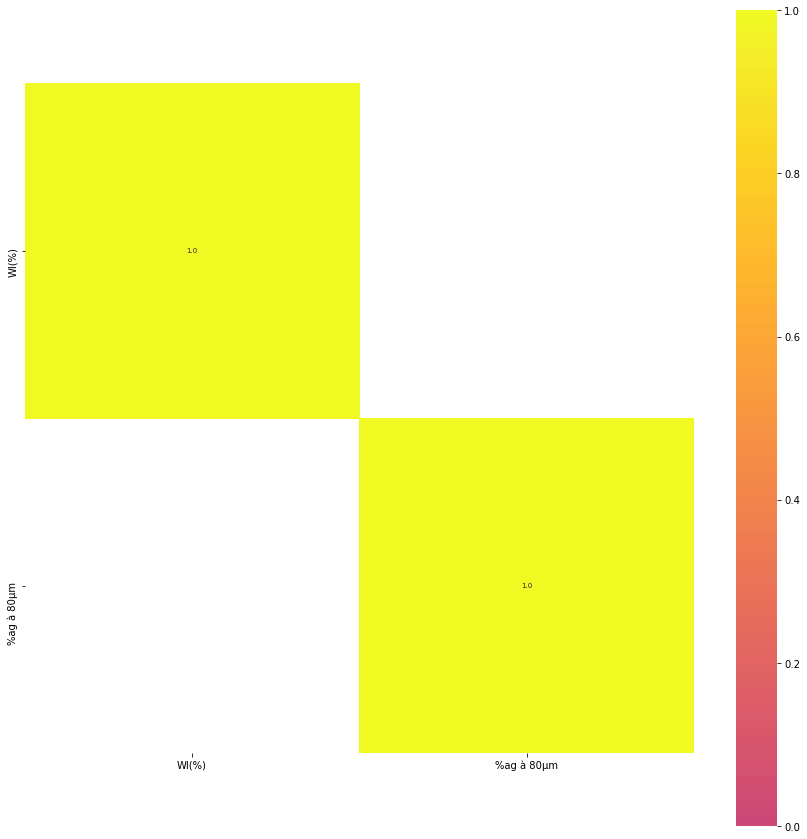

In [18]:
#If plot the Heat map for features with correlation more than 75% we get below plot 
corrmat = X.corr()
f, ax = plt.subplots(figsize=(15, 15))
sb.heatmap(corrmat, vmin = 0,vmax=1, square=True, cmap = 'plasma', annot = True,mask= corrmat < 0.75, fmt = '.1f', 
            linecolor = 'black', center = 0,annot_kws={"size": 7},)
plt.show()

On constante il ya actualement aucune relation entre les variable expliquative donc l'hypothese etant valide mais toute avant davoir ce resultat nous avons eu une grosse relation entre la variable ps et e. D'ou le pourquoi nous l'avons retirer.

## Test de Normalite et d'homoscedacite du parametre a predire cu (bar)

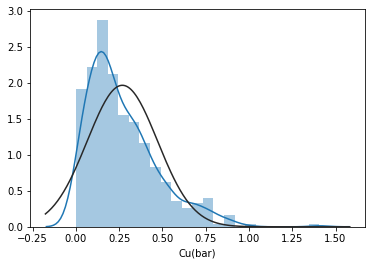

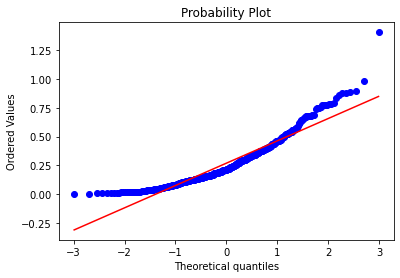

In [19]:
# Histogram and normal probability plot
sb.distplot(Y, fit = norm)
fig = plt.figure()
res = stats.probplot(Y,plot = plt)

## Test de l'hypothese de linearite avec les differentes variables et la variable a predire cu (bar) 

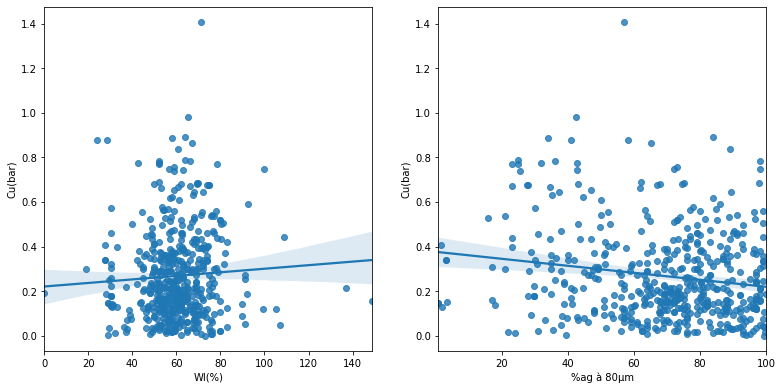

In [20]:
#  Scatterplot for numerical features
plt.figure(figsize=(20,90))
for i in range(len(features_names)):
    plt.subplot(12, 3, i+1)
    sb.regplot(x=X[features_names[i]], y=Y)

plt.show()

Dans le cas de figure du test de la linearite de la variable CU avec les differents parametres elle est valide car on decouvre que il ya une bonne relation entre les parametres et le CU.

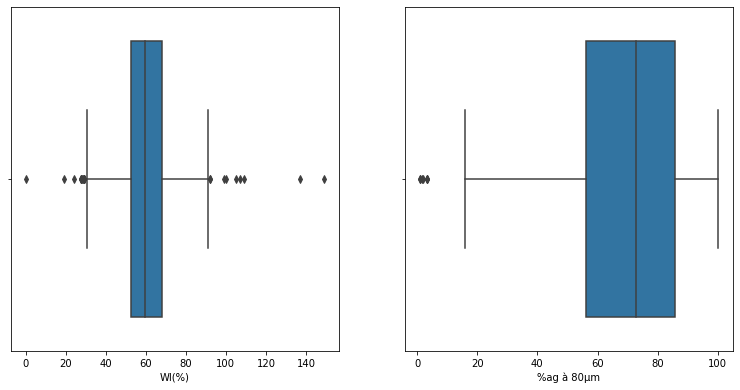

In [21]:
num_feat = X.columns

plt.figure(figsize=(20,90))
for i in range(len(num_feat)):
    plt.subplot(12, 3, i+1)
    sb.boxplot(X[num_feat[i]])

plt.show()

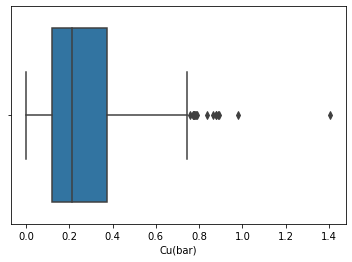

In [22]:
sb.boxplot(Y)

## Test de Normalite et d'homoscedacite du parametre a predire Φ(degree)

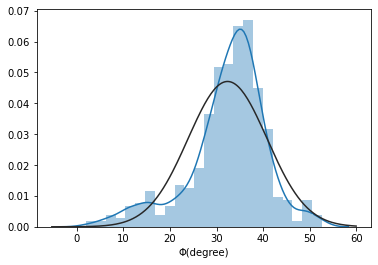

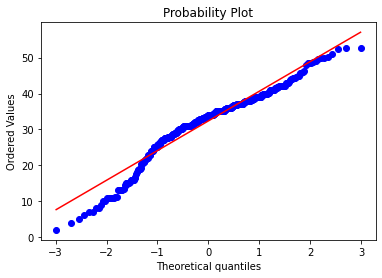

In [23]:
# Histogram and normal probability plot
sb.distplot(Y1, fit = norm)
fig = plt.figure()
res = stats.probplot(Y1,plot = plt)

Nous constatons que l'hypothese est valide vue que elle suit une lois normal donc la variance est aussi consatnt.

## Test de l'hypothese de linearite avec les differentes variables et la variable a predire Φ(degree)

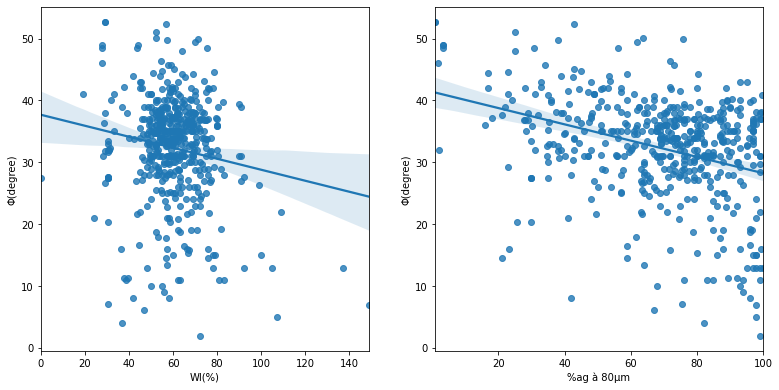

In [24]:
#  Scatterplot for numerical features
plt.figure(figsize=(20,90))
for i in range(len(features_names)):
    plt.subplot(12, 3, i+1)
    sb.regplot(x=X[features_names[i]], y=Y1)

plt.show()

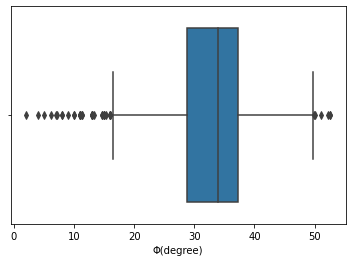

In [25]:
sb.boxplot(Y1)

In [26]:
from sklearn.feature_selection import mutual_info_regression

discrete_features = X.dtypes == int

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, Y, discrete_features)
mi_scores[::3]  

%ag à 80µm    0.051815
Name: MI Scores, dtype: float64

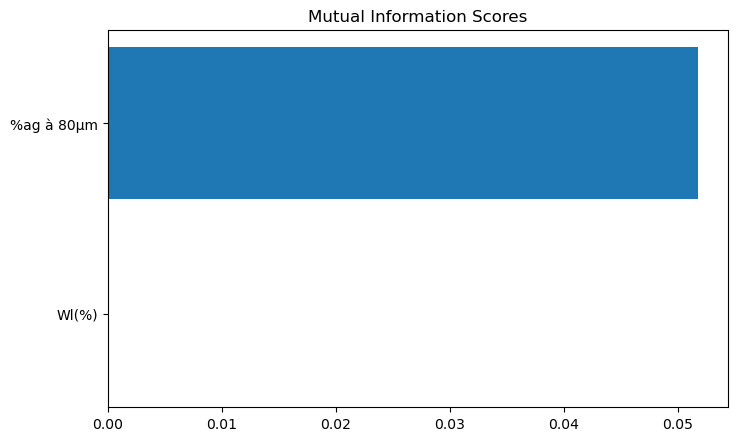

In [27]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores[0:5])

In [28]:
mi_scores = make_mi_scores(X, Y1, discrete_features)
mi_scores[::3] 

%ag à 80µm    0.086799
Name: MI Scores, dtype: float64

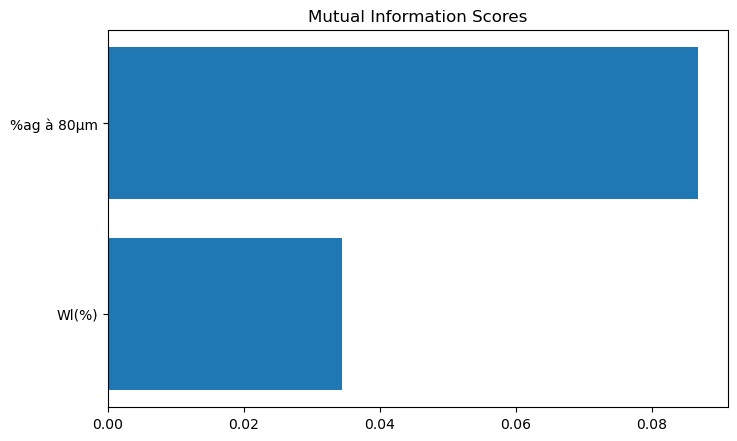

In [29]:
plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores[0:5])

Nous constatons que le Phi est aussi en bonne relation avec les differents paramteres qui sont le WI, IP et 80um.

# TRAVAUX MACHINE LEARNING ET VALIDATION DU MODEL

## Division des donnees deux partie de train et test set pour pouvoir applique notre model de machine learning

In [30]:
from sklearn.model_selection import train_test_split
import math
from sklearn.metrics import mean_squared_error

def train_model(X,Y,filename):
    X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.3, random_state=0)
    model = LinearRegression(fit_intercept=True,  copy_X=True)
    model.fit(X_train, y_train)
    joblib.dump(model,filename)
    score = model.score(X_test, y_test)
    predict = model.predict(X_test)
    predict2 = model.predict(X)
    predict_df = pd.DataFrame(predict2)
    predict_df = pd.concat([X,predict_df],axis=1)
    residuals = y_test - predict
    reg = smf.ols('y_train ~ X_train', data = X_train)
    res = reg.fit()
    print(res.summary()) 
    print(res.params)
    MSE = mean_squared_error(y_test, predict)
    RMSE = math.sqrt(MSE)
    print("Root Mean Square Error: ", RMSE)
    print("The model score is: ", score)
    coeff_df=pd.DataFrame( model.coef_[0],X_train.columns, columns=['coefficients'])
    
    return {'residuals': residuals, 'predicted': predict, 'Coeff_df':coeff_df, 'predict_df':predict_df}

In [31]:
result1 = train_model(X,Y,'modeluu.pkl')

                            OLS Regression Results                            
Dep. Variable:                y_train   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     6.912
Date:                Wed, 28 Jul 2021   Prob (F-statistic):            0.00114
Time:                        21:29:07   Log-Likelihood:                 55.266
No. Observations:                 346   AIC:                            -104.5
Df Residuals:                     343   BIC:                            -92.99
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3238      0.056      5.821      0.0

On constante que les model avec des score negative on d'habitude des intercept negative non significatif. On constate aussi que aucune des variable n'est assez pertinent pour predire le ci.

In [32]:
result2 = train_model(X,Y1, 'modeluu2.pkl')

                            OLS Regression Results                            
Dep. Variable:                y_train   R-squared:                       0.100
Model:                            OLS   Adj. R-squared:                  0.095
Method:                 Least Squares   F-statistic:                     19.15
Date:                Wed, 28 Jul 2021   Prob (F-statistic):           1.31e-08
Time:                        21:29:08   Log-Likelihood:                -1203.1
No. Observations:                 346   AIC:                             2412.
Df Residuals:                     343   BIC:                             2424.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     42.6439      2.112     20.194      0.0

In [33]:
result1['predicted']

array([0.19523422, 0.3500776 , 0.29218201, 0.26713635, 0.22413468,
       0.27090166, 0.33337199, 0.28258089, 0.20850799, 0.25294945,
       0.27444097, 0.24111155, 0.27459791, 0.30782501, 0.25877107,
       0.24474789, 0.25130011, 0.30801711, 0.21234996, 0.32424826,
       0.32175136, 0.22042022, 0.31281093, 0.29503799, 0.25278802,
       0.2772589 , 0.33050872, 0.25019548, 0.21565973, 0.27751681,
       0.25317183, 0.24045941, 0.25777917, 0.21567648, 0.23898493,
       0.24391756, 0.25620093, 0.24626434, 0.2493663 , 0.28094141,
       0.23041526, 0.23048236, 0.34681888, 0.2786914 , 0.25453033,
       0.34808342, 0.31013134, 0.37737672, 0.23946613, 0.27349708,
       0.36322201, 0.28751912, 0.31050613, 0.23260311, 0.29491284,
       0.35221373, 0.2531354 , 0.25294945, 0.26432003, 0.23673227,
       0.23406878, 0.24988392, 0.29864855, 0.26148269, 0.27877155,
       0.26189967, 0.29583803, 0.29620993, 0.26635991, 0.22864152,
       0.22508098, 0.32729634, 0.36186737, 0.32701855, 0.22302

Nous observons le meme scenario ici mais la difference est que ici la variable W et sr on sorte d'importance dans l'obtention de la variable ci prime.

In [34]:
result1['Coeff_df']

,coefficients
Wl(%),0.001367
%ag à 80µm,0.001367


In [35]:
result1['predict_df']

,Wl(%),%ag à 80µm,0
0,49.8,79.10,0.239886
1,67.4,35.30,0.348083
2,67.4,82.60,0.257221
3,59.6,87.70,0.236762
4,52.6,87.70,0.227193
...,...,...,...
491,68.0,70.00,0.242090
492,67.7,90.69,0.264734
493,58.0,72.00,0.279807
494,62.0,67.00,0.263460


# CONCLUSION

Les paramtres donnees ne peuvent pas etre utiliser pour predire le ci , ci', phi et phi'

In [36]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso, ElasticNet, BayesianRidge,RANSACRegressor,HuberRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.decomposition import PCA, KernelPCA
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_error, make_scorer
from sklearn.pipeline import Pipeline

# TESTE EN GLOBAL MODEL DE PREDICTION

In [37]:
sc = ('Scaler', StandardScaler())
est =[]
est.append(('LinearRegression', Pipeline([sc, ('LinearRegression', LinearRegression())])))
est.append(('Ridge', Pipeline([sc, ('Ridge', Ridge())])))
est.append(('Lasso', Pipeline([sc, ('Lasso', Lasso())])))
est.append(('BayesianRidge', Pipeline([sc, ('BayesianRidge', BayesianRidge())])))
est.append(('ElasticNet', Pipeline([sc,('Elastic', ElasticNet())])))
est.append(('SGD', Pipeline([sc,('SGD', SGDRegressor())])))
est.append(('Huber', Pipeline([sc,('Huber', HuberRegressor())])))
est.append(('RANSAC', Pipeline([sc,('RANSAC', RANSACRegressor())])))
est.append(('GradientBoosting', Pipeline([sc,('GradientBoosting',GradientBoostingRegressor())])))
est.append(('AdaBoost', Pipeline([sc, ('AdaBoost', AdaBoostRegressor())])))
est.append(('ExtraTree', Pipeline([sc,('ExtraTrees', ExtraTreesRegressor())])))
est.append(('RandomForest', Pipeline([sc,('RandomForest', RandomForestRegressor())]))) 
est.append(('Bagging', Pipeline([sc,('Bagging', BaggingRegressor())])))
est.append(('KNeighbors', Pipeline([sc,('KNeighbors', KNeighborsRegressor())])))
est.append(('DecisionTree', Pipeline([sc,('DecisionTree', DecisionTreeRegressor())])))
est.append(('XGB', Pipeline([sc,('XGB', XGBRegressor())])))

In [38]:
import warnings
warnings.filterwarnings(action='ignore')
seed = 4
splits = 7
models_score ={}
for i in est:
    kfold = KFold(n_splits=splits, random_state=seed, shuffle=True)
    results = cross_val_score(i[1], X, Y1, cv=kfold)
    models_score.update({i[0] : results.mean()})
    
sorted(models_score.items(), key= lambda v:v[1], reverse=True)

[('Ridge', 0.09264128490079349),
 ('LinearRegression', 0.09261941444824803),
 ('BayesianRidge', 0.09260460125485505),
 ('SGD', 0.09177515856039516),
 ('Lasso', 0.08108243015800058),
 ('Huber', 0.07709386409742167),
 ('ElasticNet', 0.07131240887452209),
 ('KNeighbors', 0.04355617064375288),
 ('AdaBoost', 0.03536545173895199),
 ('GradientBoosting', 0.0002175896447326821),
 ('RANSAC', -0.08833871521571236),
 ('RandomForest', -0.10578753379504498),
 ('Bagging', -0.1466920901347737),
 ('ExtraTree', -0.20786452062747482),
 ('XGB', -0.39862210526095676),
 ('DecisionTree', -0.7414775000973879)]

In [39]:
def Grid_Search_CV_RFR(X_train, y_train):
    from sklearn.model_selection import GridSearchCV
    from sklearn.model_selection import ShuffleSplit
    from sklearn.ensemble import RandomForestRegressor

    estimator = LinearRegression(positive=True)
    param_grid = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False],'n_jobs':[2,4,6,8]}

    grid = GridSearchCV(estimator, param_grid, n_jobs=1, cv=5,)

    grid.fit(X_train, y_train)
    
    #y_pred = grid.predict(X_test)
    #print("\nSur le jeu de test : {:.3f}".format(metrics.accuracy_score(y_test, y_pred)))

    return grid.best_score_ , grid.best_params_

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.3, random_state=0)

best_score, best_params = Grid_Search_CV_RFR(X_train, y_train)

In [41]:
print(best_score)
print(best_params)

-0.0372043464244888
{'copy_X': True, 'fit_intercept': True, 'n_jobs': 2, 'normalize': True}


In [42]:
X_train, X_test, y_train, y_test = train_test_split(X,Y1, test_size=0.3, random_state=0)

best_score, best_params = Grid_Search_CV_RFR(X_train, y_train)

In [43]:
print(best_score)
print(best_params)

-0.024217552038651214
{'copy_X': True, 'fit_intercept': True, 'n_jobs': 2, 'normalize': True}


In [44]:
X_test

,Wl(%),%ag à 80µm
90,45.1,99.00
254,68.1,34.76
284,57.0,57.00
443,71.0,80.00
337,55.0,91.00
...,...,...
484,107.0,98.00
4,52.6,87.70
319,55.0,84.00
330,60.0,82.00


Nous constatons que la regression linear marche mieux dans notre cas.